# Schaltkreise mit Qiskit in Python erstellen

In diesem ersten Notebook möchten wir die Grundlagen zur Erstellung von Schaltkreisen in Qiskit behandeln.

Bisher haben wir mit verschiedenen Composern gearbeitet. Nun wollen wir stattdessen Qiskit verwenden. Wie die beiden Tools zusammengehören zeigt die folgende Grafik. Im Quellcode werden dabei 2 verschiedene Varianten gezeigt. Links eine Variante, bei der wir die Register explizit erstellen und rechts eine vereinfachte Variante, die ausreichend ist, wenn man von jedem Register nur eins verwenden möchte.

<img src="images/Circuits.png" width="650px">

## Zwischenhäppchen

IBM hat in einem ihrer Paper einen guten Überblick über die verschiedenen Nutzergruppen von Quantencomputern gegeben. Dabei sind sie zu dem Schluss gekommen, dass es den Quantenentwickler, den Quanteninformatiker und den Phyisiker gibt. Dabei unterscheiden sich die Nutzergruppen vor allem auch im Hinblick auf die verwendeten Tools. Wir bewegen uns heute die meiste Zeit auf der Ebene des Quanteninformatikers, der Schaltkreise direkt händisch implementiert. Darüber der Quantenentwickler verwendet fertige Quantenalgorithmen, um seine Probleme zu lösen (Hierzu wird es später noch einen ganz kurzen Einblick geben). Der Physiker befindet sich auf Hardwareebene und verwendet je nach Quantentechnologie verschiedene Werkzeuge. Auf IBMs Maschinen werden dazu Mikrowellenpulse verwendet. Unter der Nutzergruppen-Grafik gibt es dazu ein Beispielbild.

![](https://firebasestorage.googleapis.com/v0/b/firescript-577a2.appspot.com/o/imgs%2Fapp%2FDaxi%2Fvue8xW4UFA.png?alt=media&token=07556223-91b7-477b-b878-9a8650b331e0)

*Quelle: A. D. Corcoles et al., „Challenges and Opportunities of Near-Term Quantum Computing Systems“, arXiv:1910.02894 [quant-ph], 2019.*

![](https://qiskit.org/textbook/images/ch-quantum-hardware/calibrating-qubits-pulse_78_0.png)

*Quelle: Qiskit-Textbook ([Link](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html))*

## Vorbereitung

Um mit Qiskit arbeiten zu können werden einige Imports benötigt. Wir werden nicht in jedem Notebook all diese Module und Klassen benötigen, allerdings schadet es in unserem Fall auch nicht immer alle möglichen Tools zu importieren.

In [1]:
import qiskit
from qiskit import *
from qiskit.visualization import *
from qiskit.providers.aer import AerSimulator
from qiskit.tools.jupyter import *

import matplotlib.pyplot as plt

import numpy as np

## Erste Schritte mit Qiskit

**Aufgabe 1:** Verwenden Sie Qiskit, um den Münzwurf zu implementieren. Speichern Sie den Schaltkreis dazu bitte in der Variablen `circ`.

In [2]:
circ = QuantumCircuit(1, 1)

circ.h(0)

circ.measure(0, 0)

Wir können uns auch die erstellten Schaltkreise mit der `draw()` Funktion zeichnen lassen. Wenn wir als Parameter `'mpl'` übergeben, wird mit Hilfe von `matplotlib` aus der ASCII-Zeichnung ein richtiges Bild.

In [3]:
circ.draw()

┌───┐┌─┐
q_0: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

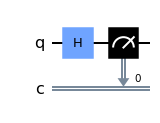

In [4]:
circ.draw('mpl')

Zum Ausführen des Codes haben wir verschiedene Möglichkeiten. Wir können einen `StatevectorSimulator`, einen `QASMSimulator` oder eine echte Maschine verwenden.

Vorstellen kann man sich die Unterschiede folgendermaßen: Der `StatevectorSimulator`, bei dem man keine Messungen im Schaltkreis haben darf, führt im Hintergrund die Matrizenrechnungen durch und gibt einem am Ende die Amplituden aus. Der `QASMSimulator` bestimmt die Wahrscheinlichkeiten der einzelnen Zustände und zieht aus dieser Wahrscheinlichkeitsverteilung jeweils einen Zustand. Diesen Simulator kann man auch noch verrauscht (engl. noisy) mit Kallibrierungdaten eines Quantencomputers ausführen, um so einen bestimmten Quantencomputer zu simulieren.

Wir werden im folgenden den `AerSimulator` verwenden, welcher ein `QASMSimulator` ist.

![](images/Ausfuehrung.jpg)

Als nächstes wollen wir den Schaltkreis auf dem Simulator ausführen und die Ergebnisse zeichnen lassen. Standardmäßig werden 1024 Shots ausgeführt, daher ergibt sich die Wahrscheinlichkeitsverteilung anhand der Ziehung von 1024 Werten.

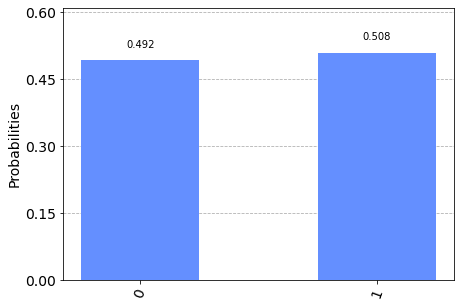

In [5]:
job = execute(circ, AerSimulator())
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

## Vorteile von Python

Wir können Python zwar nicht zur Laufzeit der Schaltkreise zu unserem Vorteil nutzen, aber wohl während der Erstellung jener.

Hier können wir Funktionen, Schleifen und Bedingungen verwenden. Im folgenden sehen Sie ein Beispiel für Simons Algorithmus:

In [6]:
def simons_oracle(secret_s: str):
    # Find the index of the first 1 in s, to be used as the flag bit
    flag_bit = secret_s.find('1')
    
    n = len(secret_s)
    
    circ = QuantumCircuit(2 * n)
    # First copy the first n qubits, so that |x>|0> -> |x>|x>
    for i in range(n):
        circ.cnot(i, i+n)
    
    # If flag_bit=-1, s is the all-zeros string, and we do nothing else.
    if flag_bit != -1:
        # Now apply the XOR with s whenever the flag bit is 1.
        for index, bit_value in enumerate(secret_s):
                
            # XOR with s whenever the flag bit is 1.
            # In terms of gates, XOR means we apply an X gate only whenever the corresponding bit in s is 1.
            # Applying this X only when the flag qubit is 1 means this is a CNOT gate.
            if(bit_value == '1'):
                circ.cnot(flag_bit, index + n)
    return circ

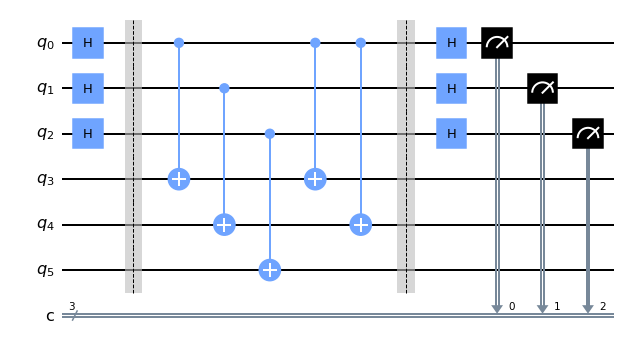

In [7]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n * 2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit.compose(simons_oracle(b), inplace=True)

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw('mpl')

**Aufgabe 2:** Führen Sie den Schaltkreis auf dem `AerSimulator` aus und zeichnen Sie das Histogram.

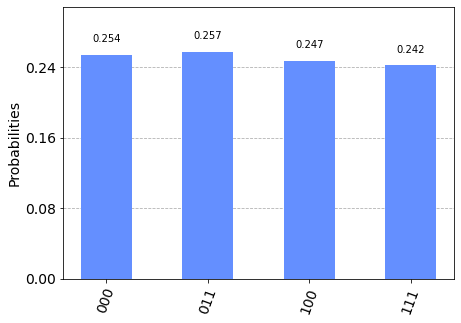

In [8]:
job = execute(simon_circuit, AerSimulator())
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

## Eigene Gates erstellen

Wie Sie im theoretischen Teil bereits erfahren haben, können wir unitäre Matrizen auf einem Quantencomputer ausführen. Dies wird im Folgenden anhand des bekannten Hadamard-Gates veranschaulicht.

In [9]:
u_matrix = np.array([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]])
special_gate = qiskit.extensions.UnitaryGate(u_matrix, label="special")

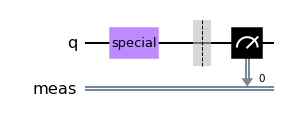

In [10]:
test_circuit = QuantumCircuit(1)
test_circuit.append(special_gate, [0]) # So können wir unser spezielles Gate anwenden
test_circuit.measure_all() # Das ist eine weitere Möglichkeit, um alle Qubits zu messen
test_circuit.draw('mpl')

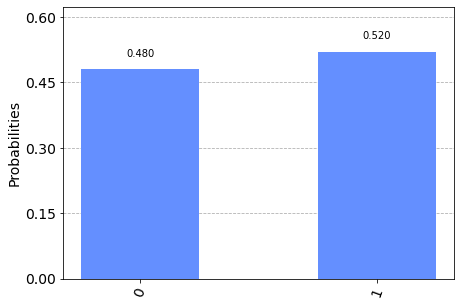

In [11]:
job_test = execute(test_circuit, AerSimulator(), shots=1024)
test_result = job_test.result()
plot_histogram(test_result.get_counts(test_circuit))

**Aufgabe 3:** Erstellen Sie ein Gate welches die Wahrscheinlichkeiten für $|0\rangle$ und $|1\rangle$ auf $1/4$ und $3/4$ setzt. Fügen Sie dieses Gate einem Schaltkreis hinzu, führen Sie diesen aus und lassen Sie das Histogram zeichnen.

In [12]:
u_matrix = np.array([[np.sqrt(1)/np.sqrt(4), np.sqrt(3)/np.sqrt(4)], [np.sqrt(3)/np.sqrt(4), -np.sqrt(1)/np.sqrt(4)]])
special_gate = qiskit.extensions.UnitaryGate(u_matrix, label="special")

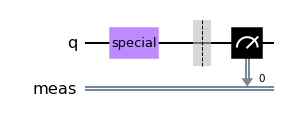

In [13]:
test_circuit = QuantumCircuit(1)
test_circuit.append(special_gate, [0]) # So können wir unser spezielles Gate anwenden
test_circuit.measure_all() # Das ist eine weitere Möglichkeit, um alle Qubits zu messen
test_circuit.draw('mpl')

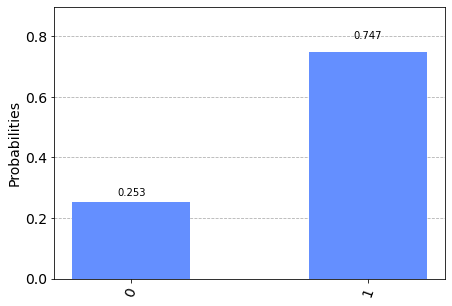

In [14]:
job_test = execute(test_circuit, AerSimulator(), shots=1024)
test_result = job_test.result()
plot_histogram(test_result.get_counts(test_circuit))

## Rechnen auf bzw. Simulation von echten Quantencomputern

Mithilfe unseres IBM-Accounts können wir über Qiskit auf echten Quantencomputern rechnern bzw. diese realitätsnah simulieren (vgl. Noise Model).

Zuerst müssen wir unseren API-Token aus der IBM-Quantum Experience holen: https://quantum-computing.ibm.com/ Diesen geben wir in der nächsten Zeile ein, um unseren Account in der Umgebung zu speichern.

In [15]:
# IBMQ.save_account('<API-Token>', hub='ibm-q', group='open', project='main', overwrite=True)

Als nächstes müssen wir unseren Account laden. Wenn wir diesen geladen haben, können wir uns einen Provider holen. I.d.R haben wir nur auf den gezeigten Zugriff.

In [16]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo

In [17]:
device_backend = provider.backend.ibm_oslo

Als nächstes erstellen wir einen Bell-Schaltkreis, um die Ergebnisse zwischen der Simulation und dem Noise-Model zu vergleichen.

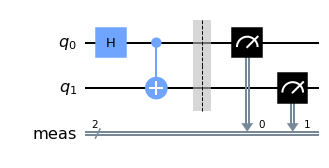

In [18]:
bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)
bell_circuit.cnot(0, 1)

bell_circuit.measure_all()

bell_circuit.draw('mpl')

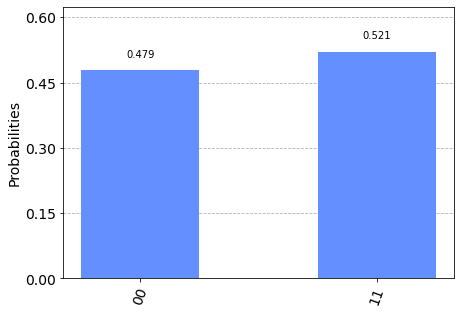

In [19]:
job = execute(bell_circuit, AerSimulator(), shots=1024)
bell_result = job.result()
plot_histogram(bell_result.get_counts(bell_circuit))

Der folgende Code zeigt, wie wir eine noisy Simulation. Dafür benötigen wir vom Quantencomputer zum einen die `coupling_map`, die uns anzeigt, welche Qubits mit welchen Qubits verbunden sind, das Noise-Model enthält die Fehlerrate pro Qubit und Gate. Zuteletzt benötigen wir noch die `basis_gates`. Diese geben an, welche Gates auf der Maschine unterstützt werden. Der Transpiler kümmert sich dann automatisch darum den eingegebenen Schaltkreis für den Quantencomputer zu übersetzen. Dieser Schritt ist auch für die Simulation wichtig, da sich dadurch die Anzahl der Gates erhöht, wodurch sich die Fehler erhöhen.

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'sx', 'cx', 'id', 'reset']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('id', [5]), ('id', [6]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('sx', [5]), ('sx', [6]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('x', [5]), ('x', [6]), ('cx', [4, 5]), ('cx', [5, 4]), ('cx', [2, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [3, 1]), ('cx', [5, 3]), ('cx', [3, 5]), ('cx', [6, 5]), ('cx', [5, 6]), ('cx', [0, 1]), ('cx', [1, 0]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('reset', [5]), ('reset', [6]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('measure', [5]), ('measure', [6])]


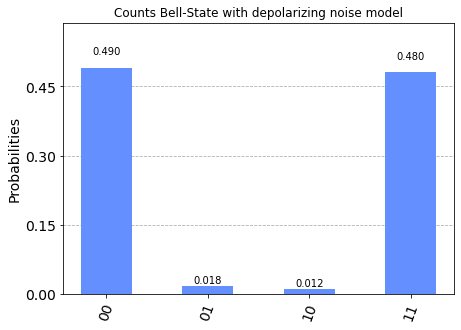

In [20]:
from qiskit.providers.aer.noise import NoiseModel

# The device coupling map is needed for transpiling to correct
# CNOT gates before simulation
coupling_map = device_backend.configuration().coupling_map

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Construct the noise model from backend properties
noise_model = NoiseModel.from_backend(device_backend)
print(noise_model)

# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

# Execute noisy simulation and get counts
result_noise = execute(bell_circuit, simulator,
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(bell_circuit)
plot_histogram(counts_noise, title="Counts Bell-State with depolarizing noise model")

Wenn wir die optimale Simulation mit der noisy Simulation vergleichen, fällt auf, dass wir mit geringer Wahrscheinlichkeit auch Zustände erhalten, die theoretisch nicht durch den Schaltkreis erzeugt werden können. Diese Zustände treten aufgrund der Fehler im Quantencomputer auf. Dabei ist es am wahrscheinlichsten, dass ein Qubit aus seinem angeregten Zustand $|1\rangle$ zurück in den Grundzustand $|0\rangle$ gefallen ist.

Natürlich könnnen wir Schaltkreise auch direkt auf einem Quantencomputer ausführen. Dafür müssen wir in der Funktion `execute` nur den `AerSimulator()` durch das `device_backend` ersetzen.

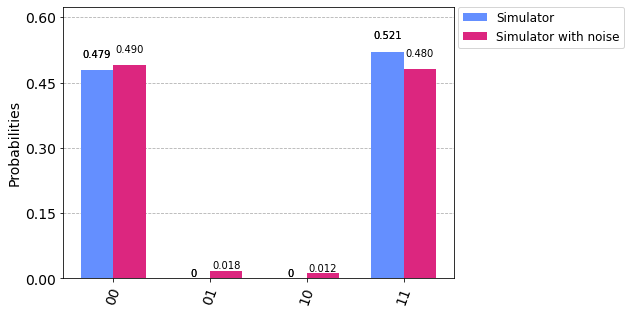

In [21]:
plot_histogram([bell_result.get_counts(bell_circuit), counts_noise], legend=['Simulator', 'Simulator with noise'])